In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
# from utils.auxfunctions import moving_window
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hidden_dim = 20
n_signals = 1
N = 64
tagset_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
class LSTM_freq(nn.Module):
    """Some Information about LSTM_freq"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(LSTM_freq, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # print(f"LSTM output: {lstm_out.shape}")
        # fc_layer = self.fc(lstm_out[:,-1,:])
        fc_layer = self.fc(lstm_out[:, -1, :])

        # print(f" fc_layer: {fc_layer.shape}")

        return torch.sigmoid(fc_layer)


In [4]:
model = LSTM_freq(n_signals, hidden_dim, tagset_size).to(device)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [5]:
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:]} \n")

Model structure: LSTM_freq(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)




In [6]:
class SineWaveDataset(torch.utils.data.Dataset):
    """Some Information about SineWaveDataset
    
    signals: dim -> (m, N)

    """

    def __init__(self, signals, labels, transform=None, target_transform=None):
        super(SineWaveDataset, self).__init__()
        self.signals = signals
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        if self.transform:
            signal = self.transform(signal)
        if self.target_transform:
            label = self.target_transform(label)
        # return torch.tensor(signal).float(), label
        return signal, label
    
class MockDataset(torch.utils.data.Dataset):
    """Some Information about MockDataset"""
    def __init__(self, signals):
        super(MockDataset, self).__init__()
        self.signals = signals

    def __getitem__(self, index):
        return self.signals[index]
        
    def __len__(self):
        return len(self.signals)


In [7]:
# Dataset Parameters
fs = 3840
N = 64
# m = 1000
m = 1600
from utils.sine_dataset import signal_dataset_creator

signals, target = signal_dataset_creator(fs, N, m)
signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).float()

In [8]:
dataset = SineWaveDataset(signals, target)
# train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, test_dataset, dev_dataset  = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=10, shuffle=True)






In [9]:
# Training
def train(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")




In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
CUDA_LAUNCH_BLOCKING =1
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------------------
loss: 0.657486  [    0/ 1440]
loss: 0.522177  [  160/ 1440]
loss: 0.394287  [  320/ 1440]
loss: 0.125111  [  480/ 1440]
loss: 0.228248  [  640/ 1440]
loss: 0.240009  [  800/ 1440]
loss: 0.071020  [  960/ 1440]
loss: 0.241285  [ 1120/ 1440]
loss: 0.041781  [ 1280/ 1440]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.083775 

Epoch 2
-----------------------------------
loss: 0.040980  [    0/ 1440]
loss: 0.035262  [  160/ 1440]
loss: 0.036722  [  320/ 1440]
loss: 0.222742  [  480/ 1440]
loss: 0.220320  [  640/ 1440]
loss: 0.041596  [  800/ 1440]
loss: 0.220373  [  960/ 1440]
loss: 0.052490  [ 1120/ 1440]
loss: 0.958136  [ 1280/ 1440]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.100925 

Done!


tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]])
torch.Size([10, 64, 1])
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)


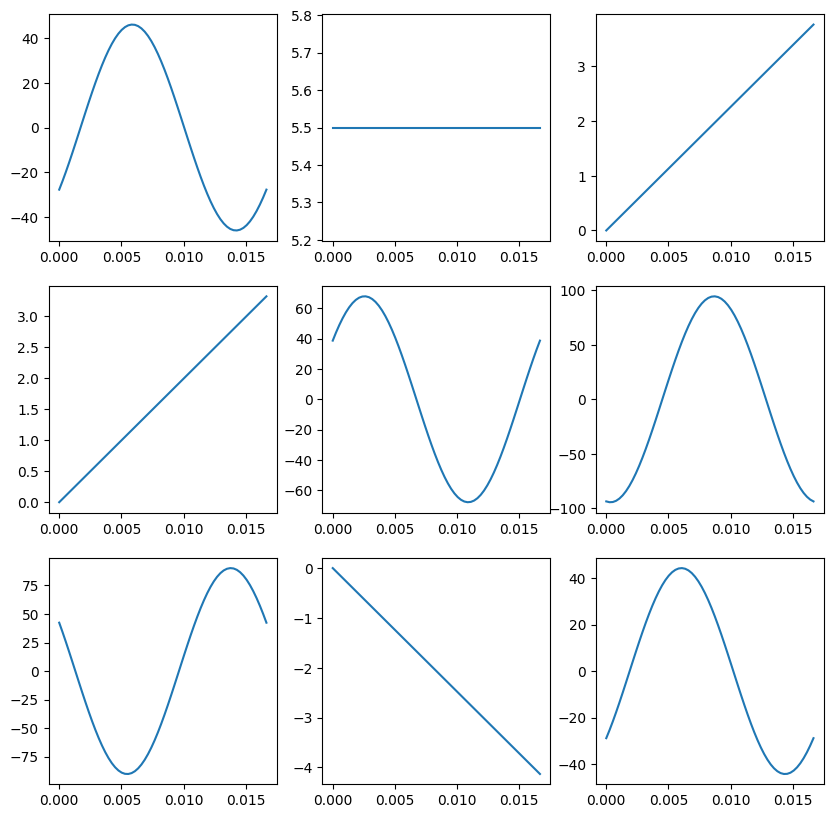

In [16]:

dataiter = iter(dev_dataloader)
signal, labels = next(dataiter)

t = np.linspace(0,N/fs,N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10,10))
cols, rows = 3, 3
for i in range(1, cols * rows +1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t,signal[i,:,0])
x = model(signal[1:10].to(device))
print(torch.round(x))


In [13]:
from utils.sine_dataset import (sine_phase_creator, 
sine_creator, 
gaussian_creator, 
constant_creator, 
sine_noise)

fs = 3840
N = 64
m = 100
t = np.linspace(0,N/fs,N)
signals_prueba = t
target = np.array([0])
signals_prueba, _ = sine_noise(signals_prueba, target, t, fs, m, mag_i=10000, mag_f=10000000)
# signals_prueba, _ = constant_creator(signals_prueba, target, N, m)
# Create Dataset
# print(t.shape)

# for i in (np.linspace(0, 100, 10)):
#     signal = np.array(i*np.sin(2*np.pi*fs*t))
#     signals_prueba = np.vstack((signals_prueba, signal))
signals_prueba = np.expand_dims(signals_prueba, axis=2)
signals_prueba = torch.from_numpy(signals_prueba).float()
print(signals_prueba.shape)

torch.Size([51, 64, 1])


torch.Size([51, 64, 1])
tensor([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


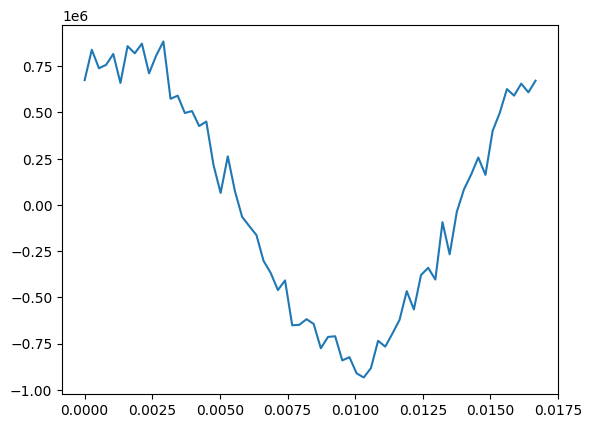

In [15]:
# torch.Size([300, 64, 1])
print(signals_prueba.shape)
x = model(signals_prueba.to(device))
plt.plot(t, signals_prueba[5,:,0])
print(torch.round(x))


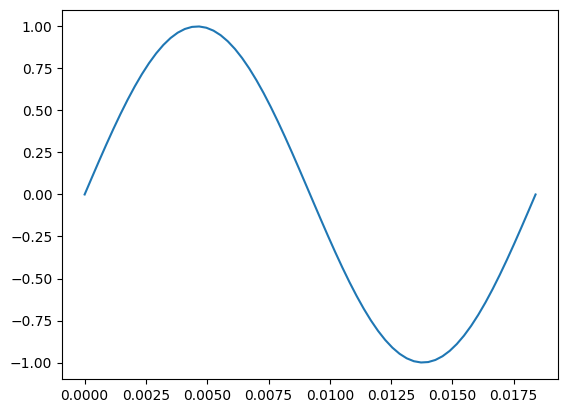

In [40]:
import numpy as np
import matplotlib.pyplot as plt
fundamental = 60
magnitude = 1
N= 64
fs = 3480
t = np.linspace(0, N / fs, N)
harmonic = 1
n = harmonic

wt = 2 * np.pi *fs * t
# phi = np.pi/2
phi = 0
phi_a = float(0) * np.pi / 180
phi_b = float(240) * np.pi / 180
phi_c = float(120) * np.pi / 180

phi_a = phi_a + phi
phi_b = phi_b + phi
phi_c = phi_c + phi
signal = magnitude * np.sin(n * (wt+ phi_a))
signal_b = magnitude * np.sin(n * (wt+ phi_b))
signal_c = magnitude * np.sin(n * (wt+ phi_c))
plt.plot(t, signal)

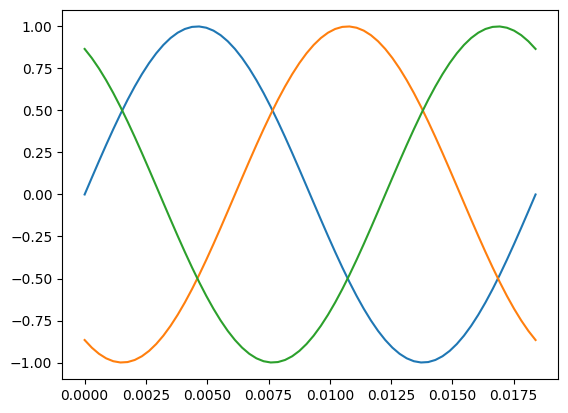

In [23]:
plt.plot(t, signal, t, signal_b, t, signal_c)